# Main Notebook for Leakage Detection

## Setup

### Google Colab Setup

In [ ]:
# Mount Google Colab files

from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection

Mounted at /content/gdrive
/content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection


### Imports

In [ ]:
!pip install wntr
%matplotlib inline
import wntr

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

     |████████████████████████████████| 4.2 MB 12.4 MB/s 


In [66]:
import utils
from utils.Network import WDN
from utils.Dataloader import Dataloader

# Attention: Run twice for real reload effect
import importlib
importlib.reload(utils.Network)
importlib.reload(utils.Dataloader)

<module 'utils.Dataloader' from '/content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection/utils/Dataloader.py'>

## Main

### Testing

In [ ]:
def plot(df, xlabel="Time (h)", ylabel="Pressure (m)", location="upper right", line_at=[], highlight_first=False):
  plt.figure()
  ax = df.plot()
  if highlight_first:
    plt.setp(ax.lines[0], linewidth=3)
  text = ax.set_xlabel(xlabel)
  text = ax.set_ylabel(ylabel)
  for line in line_at:
    plt.axvline(x=line, color='k', linestyle='--')
  plt.legend(loc = location)
  plt.show()

Nodes: ['10', '11', '12', '13', '2', '21', '22', '23', '31', '32', '9']
->Important: ['10', '11', '12', '13', '21', '22', '23', '31', '32']
Edges: [('10', '11'), ('11', '12'), ('11', '21'), ('12', '13'), ('12', '22'), ('13', '23'), ('21', '22'), ('21', '31'), ('22', '23'), ('22', '32'), ('31', '32'), ('9', '10'), ('2', '12')]


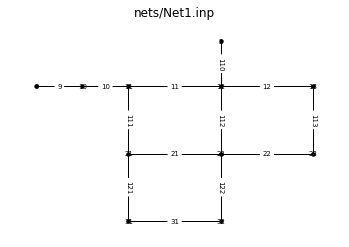

In [ ]:
wdn = WDN("nets/Net1.inp", ['10', '11','12','13','21','22','23','31','32'])
wdn.show()

In [224]:
def gen_single_data(wdn, leakage_node='', end_time=30*24, include_time=False, noise_strength=0.15):

  # Labels
  y = np.zeros((end_time+1,))

  # Construct leakages
  leakages = []
  if leakage_node:
    leakage_start = np.random.randint(end_time // 2, end_time * 9 // 10)
    leakage_strength = round(0.0009 + np.random.rand() / 2000, 4)
    leakages.append((leakage_node, leakage_strength, leakage_start+10*24, end_time+10*24))
    y[leakage_start:] = 1
  
  # Run simulation and remove first 10 convergence days
  p = wdn.simulate(end_time+10*24, leakages)[10*24:]

  # Add noise
  noise = np.random.normal(0, noise_strength, [len(p), len(wdn.important_nodes)])
  p.loc[:, wdn.important_nodes] = p.loc[:, wdn.important_nodes] + noise

  # Features
  data = Dataloader(p, wdn.important_nodes)
  X = data.get_nodes(include_time=include_time)

  return X, y

In [157]:
def show_data(X, y):
  # Get Leakage time
  first_leakage_at = np.argmax(y)
  print('Leakage at', first_leakage_at, 'Day', first_leakage_at // 24, 'Hour', first_leakage_at % 24)

  # Plot window around leakage time
  plot(X.loc[first_leakage_at-3*24:first_leakage_at+3*24, X.columns != 'hour of the day'], line_at=[first_leakage_at], location="lower left")

  # Plot whole data including y
  Xy = X.copy()
  Xy['y'] = y * (96 - 71) + 71
  plot(Xy.loc[:, Xy.columns != 'hour of the day'], location="lower left")

Leakage at 548 Day 22 Hour 20


<Figure size 432x288 with 0 Axes>

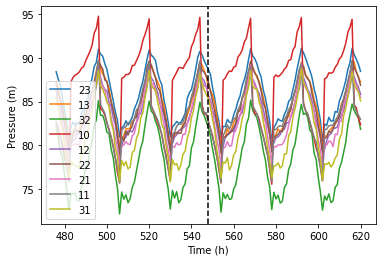

<Figure size 432x288 with 0 Axes>

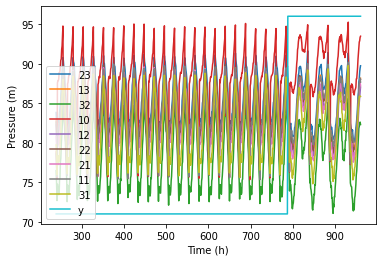

In [201]:
X, y = gen_single_data(wdn, '12', include_time=True, noise_strength=0.2)
show_data(X, y)

In [202]:
def gen_multi_data(wdn, leakage_node='', num_sim=5, days_per_sim=10, include_time=False, noise_strength=0.15):
  X_list = []
  y_list = []

  for i in range(num_sim):
    X, y = gen_single_data(wdn, leakage_node, end_time=24*days_per_sim, include_time=include_time, noise_strength=noise_strength)
    X_list.append(X)
    y_list.append(y)

  X_concat = pd.concat(X_list)
  y_concat = np.concatenate(y_list)

  X_concat.reset_index(drop=True, inplace=True)
  return X_concat, y_concat

Leakage at 197 Day 8 Hour 5


<Figure size 432x288 with 0 Axes>

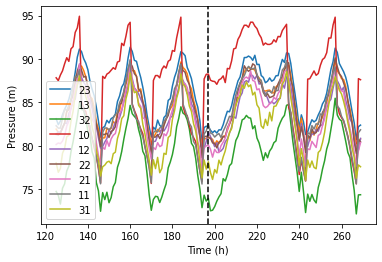

<Figure size 432x288 with 0 Axes>

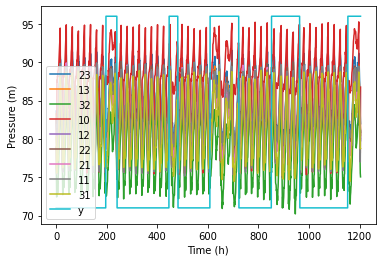

In [219]:
X, y = gen_multi_data(wdn, '12', include_time=True, noise_strength=0.3)
show_data(X, y)

In [220]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [221]:
from sklearn import svm

# Create the model
model = svm.SVC(gamma=0.001)

# Learn the digits on the train subset
model.fit(X_train, y_train)

# Predict the value of the digit on the test subset
y_pred = model.predict(X_test)

In [222]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score

print(confusion_matrix(y_test, y_pred))
print(f'Recall:      {round(recall_score(y_test, y_pred), 3)}')
print(f'Precision:   {round(precision_score(y_test, y_pred), 3)}')
print(f'Specificity: {round(recall_score(y_test, y_pred, pos_label=0), 3)}')

[[212   0]
 [ 44  46]]
Recall:      0.511
Precision:   1.0
Specificity: 1.0


Leakage at 202 Day 8 Hour 10


<Figure size 432x288 with 0 Axes>

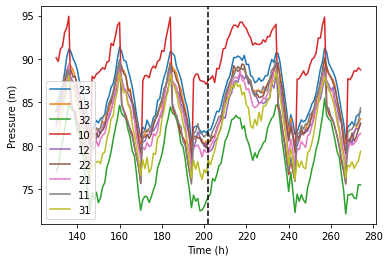

<Figure size 432x288 with 0 Axes>

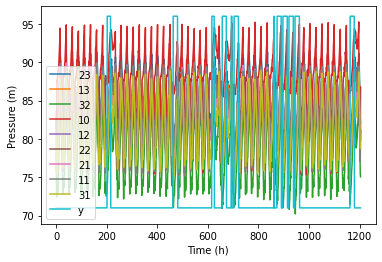

In [223]:
y_pred_all = model.predict(X)
show_data(X, y_pred_all)

### Ergebnisse:
SVM ohne 'Time of Day':
```
[[102  24]
 [ 30  25]]
Recall:      0.455
Precision:   0.51
Specificity: 0.81
```
SVM mit 'Time of Day':
```
[[104  16]
 [ 24  37]]
Recall:      0.607
Precision:   0.698
Specificity: 0.867
```



Confusion Matrix:
```
[[TN  FP]
 [FN  TP]]
```



- **Sensitivity/ Recall**: Wie gut wurden echte Lecks erkannt?
- **Precision**: Wie viele erkannte lecks waren auch wirklich Lecks?
- **Specificity**: Wie gut wurde 'alles ok' erkannt?

In [225]:
!pip install perlin-noise

In [228]:
from perlin_noise import PerlinNoise

noise = PerlinNoise(octaves=10)
pic = [noise(j/100) for j in range(100)]
df = pd.DataFrame(pic)
df

,0
0,0.000000
1,-0.061418
2,-0.142008
3,-0.231050
4,-0.304168
...,...
95,0.316250
96,0.283675
97,0.215286
98,0.132165


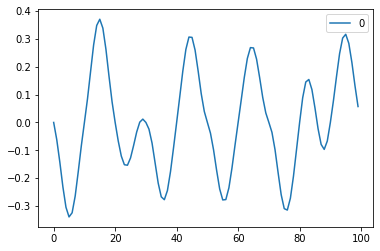

In [229]:
df.plot()
plt.show()